# SageMaker Deployment

In [1]:
%load_ext autoreload
%autoreload 2
from sagemaker_inference import *

style = 'vangogh'

### Select random image

In [2]:
import pandas as pd
d = pd.read_csv('/home/ec2-user/SageMaker/data/Picasso.csv')

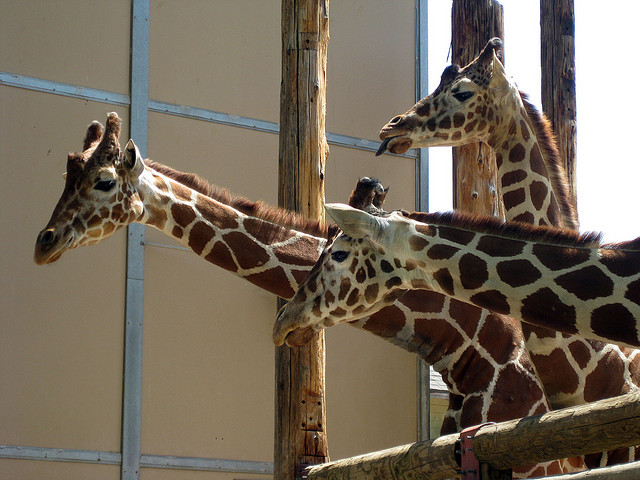

In [3]:
test_image = d.sample().content_.values[0]
img = PIL.Image.open(test_image)

with open(test_image, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

img

In [4]:
img.size

(640, 480)

### Test deployment script without endpoint creation

In [5]:
model = model_fn(f"./{style}")

In [6]:
im = input_fn(payload)

In [7]:
type(im), im['img'].shape, im['size']

(dict, torch.Size([3, 360, 360]), (640, 480))

In [8]:
out = predict_fn(im, model)

In [9]:
type(out), out['img'].shape, out['size']

(dict, torch.Size([3, 360, 360]), (640, 480))

In [10]:
pred = output_fn(out)

In [11]:
j = json.loads(pred)

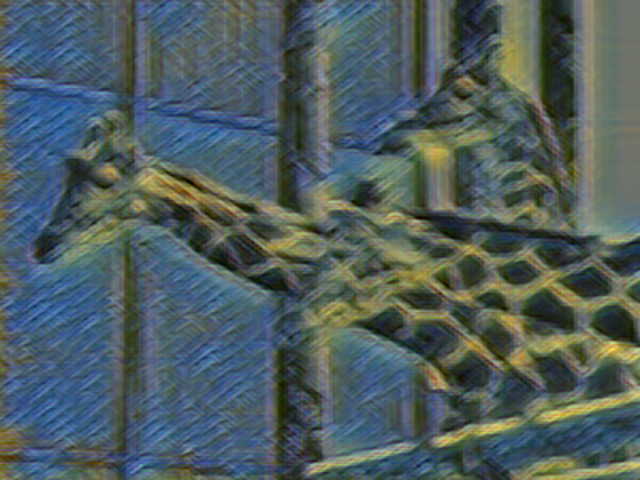

In [12]:
base64_to_image(j['prediction'])

### Create `model.tar.gz`  and upload model to S3

In [13]:
import tarfile
with tarfile.open(f'./{style}/model.tar.gz', 'w:gz') as f:
    t = tarfile.TarInfo('models')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add(f'{style}/model.pth', arcname='model.pth')

In [14]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = "visualneurons.com-fast-nst"
prefix = style
model_artefact = sagemaker_session.upload_data(path=f'./{style}/model.tar.gz', bucket=bucket, key_prefix=prefix)

In [15]:
model_artefact

's3://visualneurons.com-fast-nst/vangogh/model.tar.gz'

### Testing SageMaker endpoint

In [16]:
from sagemaker.pytorch import PyTorchModel
role = sagemaker.get_execution_role()

In [17]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                         deserializer=json_deserializer, content_type='image/jpeg')

In [18]:
pytorch_model = PyTorchModel(model_data=model_artefact, role=role,framework_version='1.0.0', name=style,
                             entry_point='sagemaker_inference.py',predictor_cls=ImagePredictor)

In [21]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


In [19]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------!

In [20]:
sag = predictor.predict(payload)

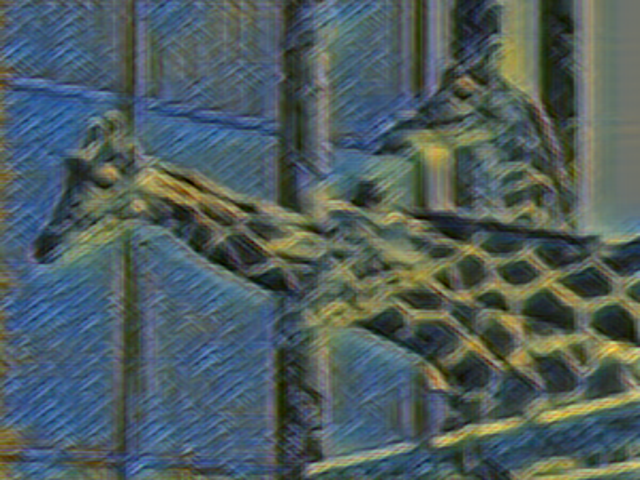

In [21]:
base64_to_image(sag['prediction'])